In [3]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymongo
import seaborn as sns
import humanize
import warnings
import os

In [4]:
warnings.filterwarnings('ignore')

load_dotenv()

True

In [5]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80

In [6]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

apartments.head(3)

,codigo,tipo_propiedad,tipo_operacion,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,...,vigilancia,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm,parque_cercano,distancia_parque_m,is_cerca_parque
0,4133491,APARTAMENTO,VENTA,339000000.0,76.0,3.0,2.0,300000.0,1.0,BRITALIA,...,0.0,False,SUBA,URB. PICADELLY,Toberin - Foundever,1142.45,0,PARQUE VECINAL DESARROLLO CANTALEJO URBANIZACI...,426.09,1
1,3889852,APARTAMENTO,VENTA,223000000.0,63.0,3.0,2.0,NaN,0.0,SAN CRISTOBAL NORTE,...,0.0,False,USAQUEN,BARRANCAS PERLAS DEL NORTE,Mazurén,2384.89,0,PARQUE ZONAL ALTA BLANCA,472.47,1
2,4386770,APARTAMENTO,VENTA,440898168.0,54.0,3.0,2.0,305000.0,0.0,LA SABANA,...,0.0,False,LOS MARTIRES,SAN VICTORINO,De La Sabana,232.22,1,PARQUE METROPOLITANO TERCER MILENIO,961.29,0


In [5]:
# apartments = pd.read_csv('../data/processed/apartments.csv')
# print(apartments.shape)
# apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]
# apartments = apartments.drop(['precio_arriendo'], axis=1)
# apartments.head()

In [7]:
apartments.shape

(26706, 45)

In [8]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26706 entries, 0 to 43012
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   codigo                   26706 non-null  object 
 1   tipo_propiedad           26706 non-null  object 
 2   tipo_operacion           26706 non-null  object 
 3   precio_venta             26706 non-null  float64
 4   area                     26706 non-null  float64
 5   habitaciones             26706 non-null  float64
 6   banos                    26706 non-null  float64
 7   administracion           24378 non-null  float64
 8   parqueaderos             26706 non-null  float64
 9   sector                   25935 non-null  object 
 10  estrato                  26705 non-null  float64
 11  antiguedad               26697 non-null  object 
 12  latitud                  26706 non-null  float64
 13  longitud                 26706 non-null  float64
 14  direccion                79

In [9]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque'],
      dtype='object')

In [10]:
apartments['datetime'] = pd.to_datetime(apartments['datetime'])
apartments['last_view'] = pd.to_datetime(apartments['last_view'])

In [11]:
fotmat_tick_humanize = lambda x, pos: humanize.intword(x)

# Elimindando Outliers

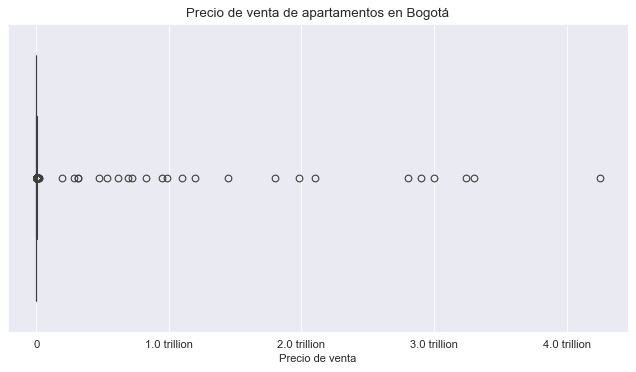

In [12]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='precio_venta', data=apartments)
plt.title('Precio de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))

In [13]:
Q1 = apartments['precio_venta'].quantile(0.25)
Q3 = apartments['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.8 * IQR
upper = Q3 + 1.8 * IQR

if lower < 0:
    lower = Q1 - 0.4 * IQR

outliers = apartments.loc[(apartments['precio_venta'] < lower) | (apartments['precio_venta'] > upper)]
outliers.shape
# lower, upper

(1573, 45)

In [15]:
apartments = apartments[(apartments['precio_venta'] > lower) & (apartments['precio_venta'] < upper)]
apartments.shape

(25132, 45)

# Analisis Univariado

In [16]:
# selecionar todos los meses de datetime
apartments['month'] = apartments['datetime'].dt.month

In [17]:
apartments['month_name'] = apartments['month'].replace({1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
                                   7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})

In [18]:
apartments['month_name'].value_counts()

month_name
Julio         15513
Agosto         9597
Septiembre       20
Name: count, dtype: int64

In [26]:
apartments['last_view_month'] = apartments['last_view'].dt.month
apartments['last_view_month_name'] = apartments['last_view_month'].replace({1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})
apartments['last_view_month_name'].value_counts()

last_view_month_name
Agosto        18534
Julio          6150
Septiembre      446
Name: count, dtype: int64

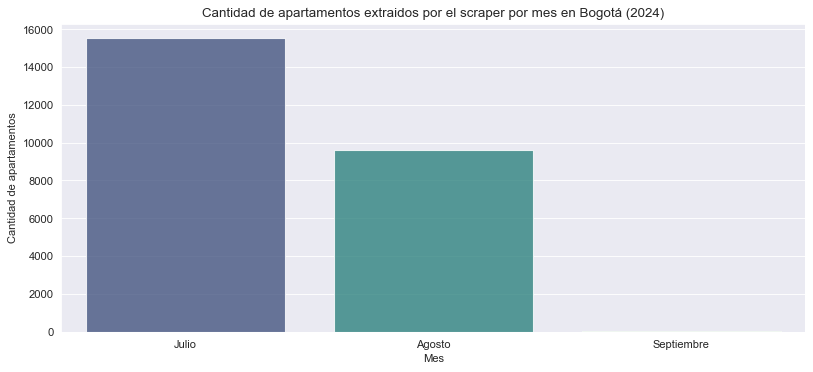

In [20]:
plt.figure(figsize=(12, 5))

sns.countplot(
    x='month_name', 
    data=apartments,
    palette='viridis',
    alpha=.8,
    # ordenar por el mes
    order=['Julio', 'Agosto', 'Septiembre']
)

plt.title('Cantidad de apartamentos extraidos por el scraper por mes en Bogotá (2024)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de apartamentos')
# plt.savefig('../visualizations/apartments_by_month.png', bbox_inches='tight')
plt.show()

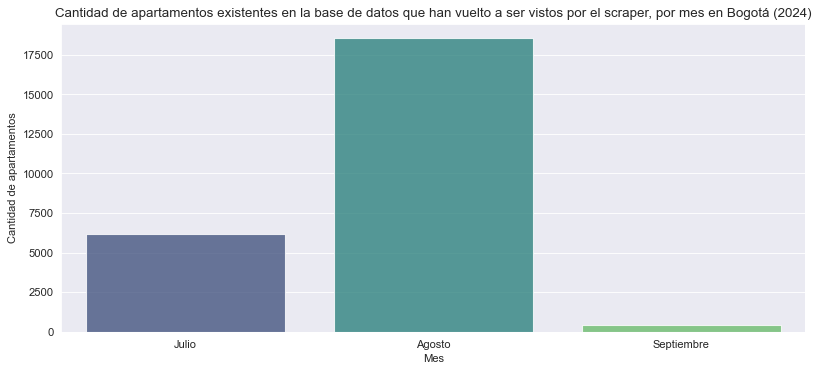

In [30]:
plt.figure(figsize=(12, 5))

sns.countplot(
    x='last_view_month_name', 
    data=apartments,
    palette='viridis',
    alpha=.8,
    # ordenar por el mes
    order=['Julio', 'Agosto', 'Septiembre']
)

plt.title('Cantidad de apartamentos existentes en la base de datos que han vuelto a ser vistos por el scraper, por mes en Bogotá (2024)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de apartamentos')
# plt.savefig('../visualizations/apartments_viewed_by_month.png', bbox_inches='tight')
plt.show()

In [21]:
apartments['localidad'].value_counts()

localidad
USAQUEN               9331
CHAPINERO             5933
SUBA                  4869
FONTIBON              1050
KENNEDY                872
ENGATIVA               764
TEUSAQUILLO            738
BOSA                   316
SANTA FE               301
CIUDAD BOLIVAR         213
LOS MARTIRES           160
BARRIOS UNIDOS         153
PUENTE ARANDA          112
RAFAEL URIBE URIBE      92
USME                    76
SAN CRISTOBAL           49
ANTONIO NARINO          42
CANDELARIA              38
TUNJUELITO              23
Name: count, dtype: int64

## Precio de Venta

In [22]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,"25,132.0","856,006,429.1863362","623,713,921.3005764","76,000,000.0","390,000,000.0","660,000,000.0","1,200,000,000.0","2,915,000,000.0"


In [23]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intword(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,25.1 thousand,856.0 million,623.7 million,76.0 million,390.0 million,660.0 million,1.2 billion,2.9 billion


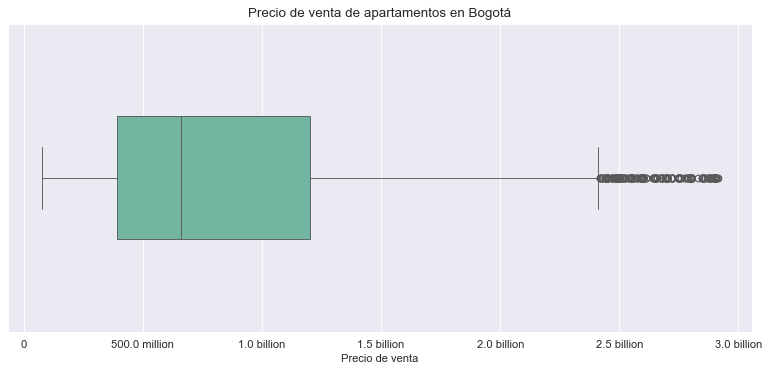

In [24]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.show()

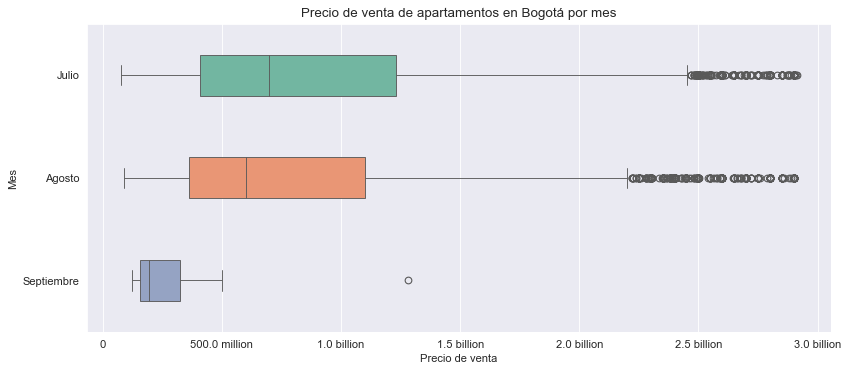

In [25]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    y='month_name',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá por mes')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.ylabel('Mes')
plt.show()

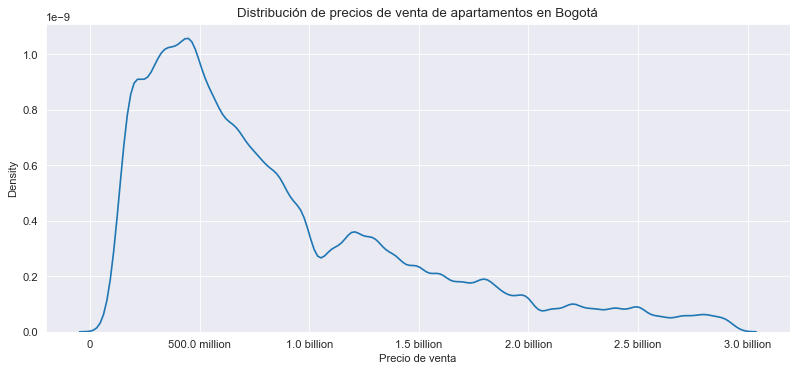

In [31]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [32]:
stat, p = stats.normaltest(apartments['precio_venta'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=4304.440, p=0.000


In [33]:
alpha = 0.05
if p > alpha:
    print('La muestra parece Gaussiana (no rechazar H0)')
else:
    print('La muestra no parece Gaussiana (rechazar H0)')

La muestra no parece Gaussiana (rechazar H0)


In [34]:
apartments['is_cerca_estacion_tm'].value_counts()

is_cerca_estacion_tm
0    19858
1     5274
Name: count, dtype: int64

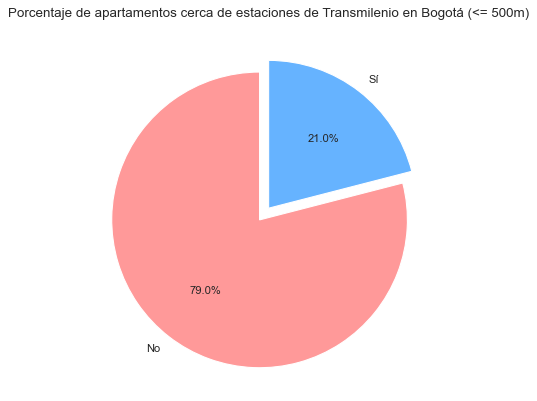

In [38]:
# pie chart
plt.figure(figsize=(6, 6))

apartments['is_cerca_estacion_tm'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999','#66b3ff'],
    explode=(0.1, 0),
    labels=['No', 'Sí'],
)

plt.title('Porcentaje de apartamentos cerca de estaciones de Transmilenio en Bogotá (<= 500m)')
plt.ylabel('')
plt.xlabel('')
plt.show()

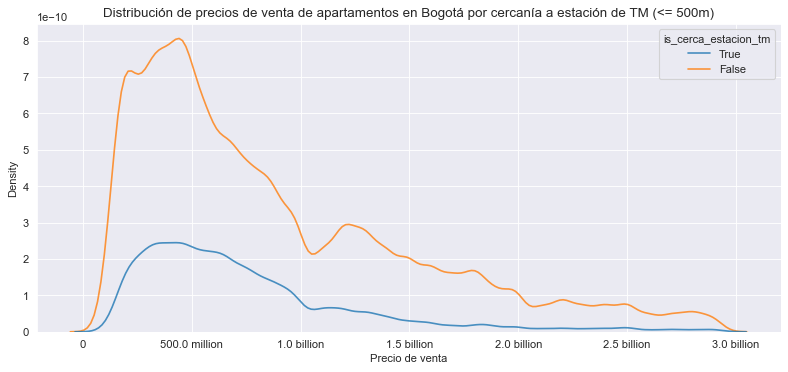

In [39]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    bw_adjust=.5,
    hue_order=[True, False],
    alpha=.8,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

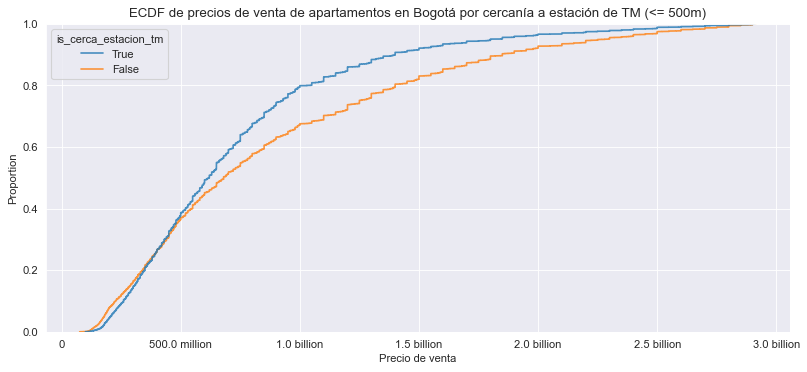

In [40]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    alpha=.8,
)

plt.title('ECDF de precios de venta de apartamentos en Bogotá por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [41]:
# stats de precio por cada mes
stats_month = apartments.groupby('month_name')['precio_venta'].describe()
stats_month

,count,mean,std,min,25%,50%,75%,max
month_name,,,,,,,,
Agosto,9597.0,8.060088e+08,6.076282e+08,88000000.0,360000000.0,600000000.0,1.100000e+09,2.900000e+09
Julio,15513.0,8.875948e+08,6.314762e+08,76000000.0,410000000.0,697474539.0,1.230000e+09,2.915000e+09
Septiembre,20.0,2.924464e+08,2.636714e+08,121000000.0,155699750.0,195665000.0,3.240000e+08,1.280000e+09


In [42]:
stats_month_last_view = apartments.groupby('last_view_month_name')['precio_venta'].describe()
stats_month_last_view

,count,mean,std,min,25%,50%,75%,max
last_view_month_name,,,,,,,,
Agosto,18534.0,9.011294e+08,6.342459e+08,76000000.0,420000000.0,710000000.0,1.250000e+09,2.915000e+09
Julio,6150.0,7.640020e+08,5.779875e+08,88000000.0,350000000.0,570000000.0,9.800000e+08,2.910000e+09
Septiembre,446.0,2.471510e+08,1.582717e+08,83000000.0,155000000.0,192157894.5,2.971350e+08,1.420000e+09


In [43]:
# stats de precio por localidad

stats_localidad = apartments.groupby('localidad')['precio_venta'].describe()
stats_localidad.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
localidad,,,,,,,,
CHAPINERO,5933.0,1.343993e+09,6.849646e+08,155000000.0,790000000.0,1.260000e+09,1.800000e+09,2.915000e+09
USAQUEN,9331.0,9.033966e+08,5.513909e+08,145000000.0,480000000.0,7.500000e+08,1.200000e+09,2.900000e+09
SUBA,4869.0,6.521451e+08,4.537726e+08,90000000.0,348000000.0,5.300000e+08,8.000000e+08,2.900000e+09
TEUSAQUILLO,738.0,6.021866e+08,3.172770e+08,147000000.0,395000000.0,5.450000e+08,7.190000e+08,2.700000e+09
FONTIBON,1050.0,4.991213e+08,3.722158e+08,119900000.0,260000000.0,3.905000e+08,6.000000e+08,2.900000e+09
SANTA FE,301.0,4.951454e+08,2.853950e+08,115000000.0,280000000.0,4.300000e+08,6.550000e+08,1.900000e+09
CANDELARIA,38.0,4.613431e+08,2.396740e+08,173000000.0,323750000.0,4.265000e+08,4.500000e+08,1.500000e+09
BARRIOS UNIDOS,153.0,4.498418e+08,1.635973e+08,160000000.0,340000000.0,4.250000e+08,5.500000e+08,1.250000e+09
PUENTE ARANDA,112.0,4.282164e+08,3.506743e+08,110000000.0,225000000.0,3.005000e+08,4.500000e+08,2.328144e+09


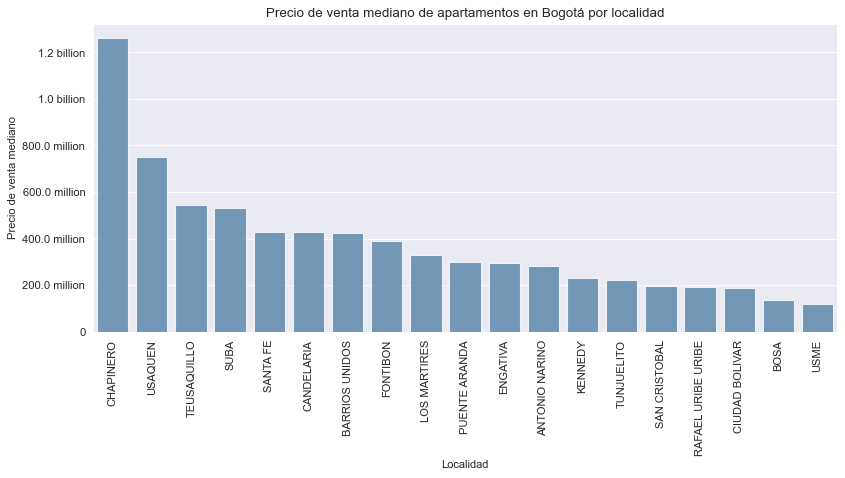

In [44]:
plt.figure(figsize=(12, 5))

sns.barplot(
    x=stats_localidad.index,
    y=stats_localidad['50%'],
    alpha=.8,
    order=stats_localidad.sort_values(by='50%', ascending=False).index,
    color='steelblue',
)

plt.title('Precio de venta mediano de apartamentos en Bogotá por localidad')
plt.xlabel('Localidad')
plt.ylabel('Precio de venta mediano')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xticks(rotation=90)
plt.show()

In [45]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque', 'month', 'month_name',
       'last_view_month', 'last_view_month_name'],
      dtype='object')

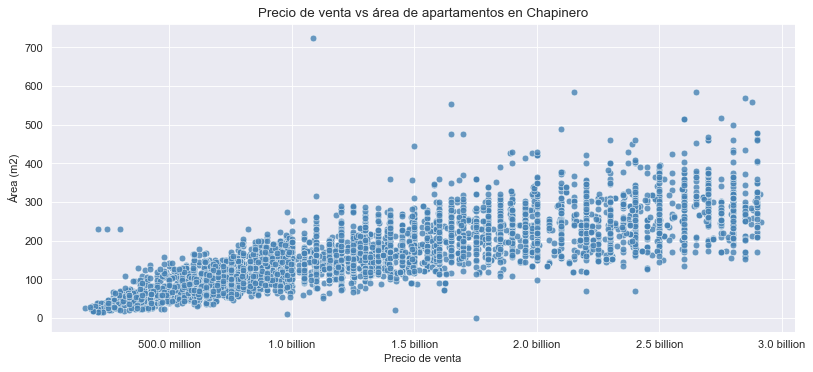

In [46]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    data=apartments.loc[apartments['localidad'] == 'CHAPINERO'],
    x='precio_venta',
    y=apartments['area'].loc[(apartments['localidad'] == 'CHAPINERO') & (apartments['area'] < 800) & (apartments['area'] > 0)],
    alpha=.8,
    color='steelblue',
)

plt.title('Precio de venta vs área de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.ylabel('Área (m2)')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [47]:
apartments['is_cerca_parque'].value_counts()

is_cerca_parque
0    18626
1     6506
Name: count, dtype: int64

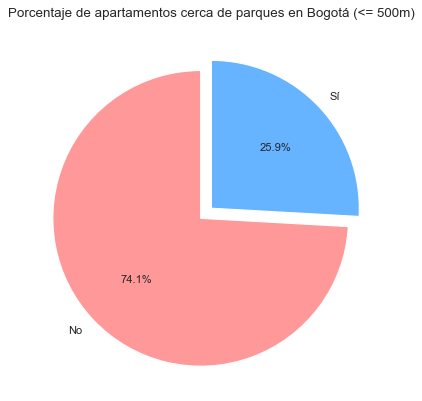

In [50]:
# pie chart
plt.figure(figsize=(6, 6))

apartments['is_cerca_parque'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999','#66b3ff'],
    explode=(0.1, 0),
    labels=['No', 'Sí'],
)

plt.title('Porcentaje de apartamentos cerca de parques en Bogotá (<= 500m)')
plt.ylabel('')
plt.xlabel('')
plt.show()

In [51]:
# cual es la localidad con apartamentos mas cerca de parques
apartments.groupby('localidad')['is_cerca_parque'].sum().sort_values(ascending=False)

localidad
CHAPINERO             2164
SUBA                  1480
USAQUEN               1271
KENNEDY                304
FONTIBON               272
TEUSAQUILLO            269
ENGATIVA               163
BOSA                   143
CIUDAD BOLIVAR         134
SANTA FE                75
BARRIOS UNIDOS          57
USME                    47
PUENTE ARANDA           34
ANTONIO NARINO          27
LOS MARTIRES            27
SAN CRISTOBAL           16
RAFAEL URIBE URIBE      15
TUNJUELITO               8
CANDELARIA               0
Name: is_cerca_parque, dtype: int64

Text(0, 0.5, 'Localidad')

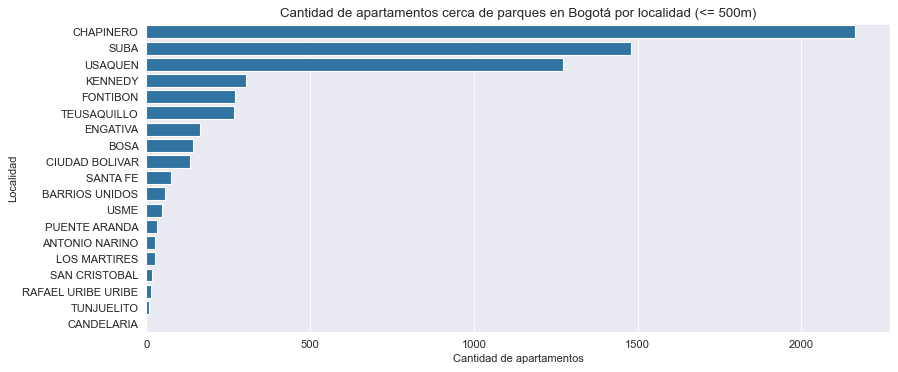

In [56]:
plt.figure(figsize=(12, 5))

sns.barplot(
    y=apartments.groupby('localidad')['is_cerca_parque'].sum().sort_values(ascending=False).index,
    x=apartments.groupby('localidad')['is_cerca_parque'].sum().sort_values(ascending=False),
)

plt.title('Cantidad de apartamentos cerca de parques en Bogotá por localidad (<= 500m)')
plt.xlabel('Cantidad de apartamentos')
plt.ylabel('Localidad')

Text(0.5, 1.0, 'Distribución de precios de venta de apartamentos en Bogotá por cercanía a parque (<= 500m)')

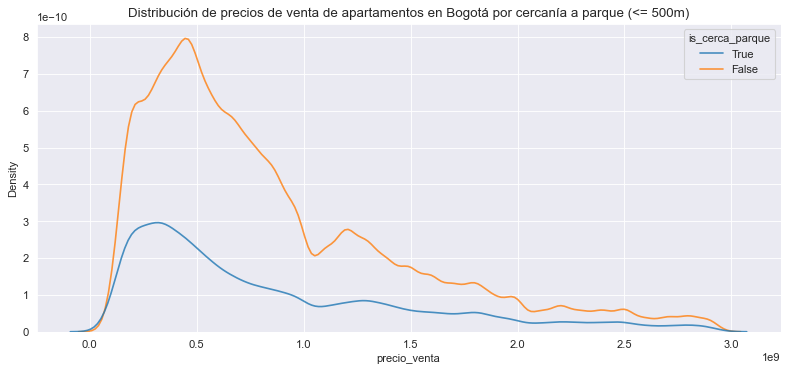

In [48]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    hue='is_cerca_parque',
    bw_adjust=.5,
    hue_order=[True, False],
    alpha=.8,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá por cercanía a parque (<= 500m)')


In [49]:
apartments.website.value_counts()

website
metrocuadrado.com    24336
habi.co                794
Name: count, dtype: int64